## Solar project - in progress

### 1. Imports

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

### 2. Data Loading

In [67]:
# Loading data

generation = pd.read_csv('Plant_1_Generation_Data.csv', sep=';')
weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

Datas for the first week of June was mistakenly interpreted by to_datetime: day was replaced by month and vice versa. There was a necesity to define which of them is first, like below.

In [68]:
generation['DATE_TIME'] = pd.to_datetime(generation['DATE_TIME'], dayfirst = [False])

At first let's see the amount of produced energy over a given period of time. To this there is necesity to convert power to energy - in this case to divide it by 4. The amount of energy will be cumulated for days.

In [69]:
sumarized_generation = generation.groupby(['DATE_TIME'], sort=False).sum().reset_index()
sumarized_generation['DATE_TIME'] = pd.to_datetime(sumarized_generation['DATE_TIME'])
weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])

sumarized_generation.drop(columns=['PLANT_ID'], inplace=True)

### 3. Preparing DataFrame

Sumarized data of all inverters was merged in one DataFrame with weather data, like below.

In [70]:
z = sumarized_generation.merge(weather, on='DATE_TIME')
z.drop(columns=['PLANT_ID', 'SOURCE_KEY'], inplace=True)

To calculate the amount of produced energy there is a necesity to calculate 1 hour data stamp, not 15 minutes one, because we need to calculate energy unit 1 kWh which is 1 kW (power unit) per hour.

In [71]:
sumarized_generation['ENERGY'] = sumarized_generation['AC_POWER']/4
sumarized_generation['DATE'] = pd.to_datetime(sumarized_generation['DATE_TIME']).dt.date

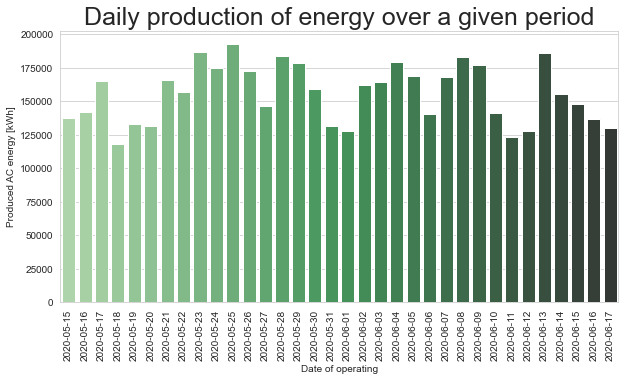

In [72]:
sns.set_style("whitegrid")

fig, total_production = plt.subplots(figsize=(10,5))
total_production = sns.barplot(x = "DATE", y = "ENERGY",
                              data = sumarized_generation,
                              estimator = sum,
                              ci = None,
                              palette = "Greens_d")

total_production.set(xlabel='Date of operating', ylabel='Produced AC energy [kWh]')
plt.title('Daily production of energy over a given period', fontsize=25)
plt.xticks(rotation=90)

plt.show()

In the picture above it is visible that everyday's amount of produced energy is diferent. In the next parts of this project I will try to discover reasons of that fact - dependencies of operating on weather conditions.

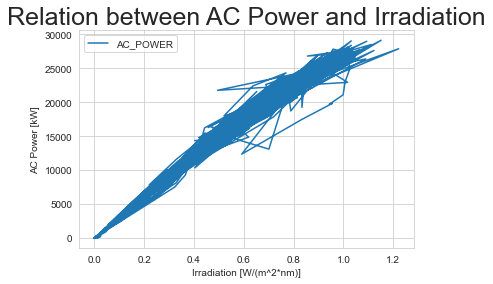

In [73]:
plot2 = z.plot('IRRADIATION', 'AC_POWER')
plot2.set(xlabel='Irradiation [W/(m^2*nm)]', ylabel='AC Power [kW]')
plt.title('Relation between AC Power and Irradiation', fontsize=25)
plt.show()

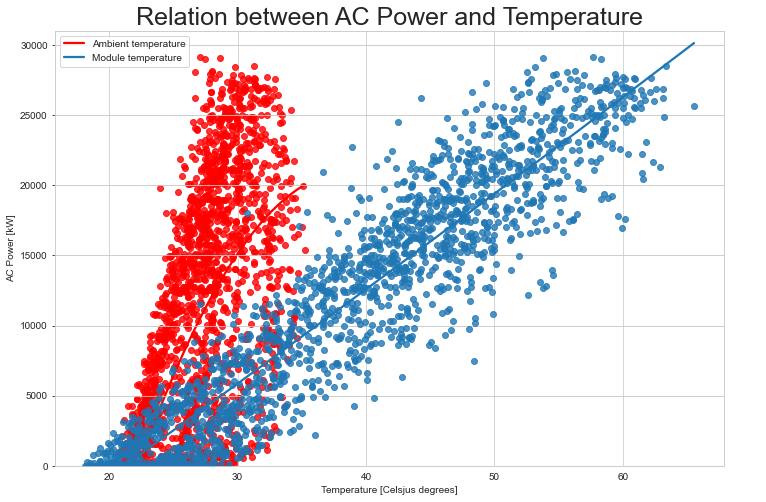

In [74]:
fig, ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()
sns.regplot(x="AMBIENT_TEMPERATURE", y="AC_POWER", data=z, order=2, ax=ax, color='red', ci = None)
sns.regplot(x="MODULE_TEMPERATURE", y="AC_POWER", data=z, order=2, ax=ax2, ci = None)


ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Ambient temperature", "Module temperature"])

plt.title('Relation between AC Power and Temperature', fontsize=25)
ax.set(xlabel='Temperature [Celsjus degrees]', ylabel='AC Power [kW]')
ax2.set(ylabel='')
ax.set_ylim(0,31000)
ax2.set_ylim(0,31000)
ax2.tick_params(axis='y', colors='white')
plt.show()

#delete regression from the plot and change legend

In [75]:
z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3157 entries, 0 to 3156
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   DC_POWER             3157 non-null   float64       
 2   AC_POWER             3157 non-null   float64       
 3   DAILY_YIELD          3157 non-null   float64       
 4   TOTAL_YIELD          3157 non-null   float64       
 5   AMBIENT_TEMPERATURE  3157 non-null   float64       
 6   MODULE_TEMPERATURE   3157 non-null   float64       
 7   IRRADIATION          3157 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 222.0 KB


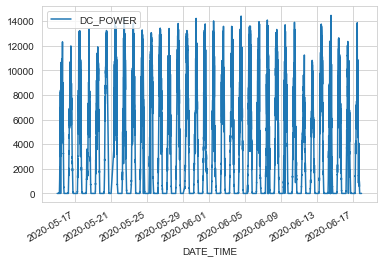

In [76]:
to_train = generation.merge(weather, on='DATE_TIME', how='outer')
to_train.interpolate(method ='ffill', inplace = True) 
to_train.plot(x='DATE_TIME', y='DC_POWER')
to_train = to_train.sort_values('DATE_TIME').reset_index()

In [77]:
to_train.drop(columns=['PLANT_ID_y','PLANT_ID_x', 'SOURCE_KEY_y', 'index'], inplace = True)

In [78]:
to_train.rename(columns={"SOURCE_KEY_x": "INVERTER"}, inplace = True)
to_train

,DATE_TIME,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,zVJPv84UY57bAof,0.0,0.0,0.0,7116151.0,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,z9Y9gH1T5YWrNuG,0.0,0.0,0.0,7007866.0,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,wCURE6d3bPkepu2,0.0,0.0,0.0,6782598.0,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...
68798,2020-06-17 23:45:00,VHMLBKoKgIrUVDU,0.0,0.0,6007.0,7456208.0,21.909288,20.427972,0.0
68799,2020-06-17 23:45:00,McdE0feGgRqW7Ca,0.0,0.0,5992.0,7408587.0,21.909288,20.427972,0.0
68800,2020-06-17 23:45:00,7JYdWkrLSPkdwr4,0.0,0.0,5856.0,7846821.0,21.909288,20.427972,0.0
68801,2020-06-17 23:45:00,uHbuxQJl8lW7ozc,0.0,0.0,5967.0,7287002.0,21.909288,20.427972,0.0


In [79]:
to_drop = ['DAILY_YIELD', 'TOTAL_YIELD']
kolumny = list(to_train.columns)

for i in to_drop:
    kolumny.remove(i)

to_correlation = a[kolumny]
to_correlation

,DATE_TIME,INVERTER,DC_POWER,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0,0.0,0.0,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,1,0.0,0.0,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,2,0.0,0.0,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,3,0.0,0.0,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,4,0.0,0.0,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...
68769,2020-06-17 23:45:00,17,0.0,0.0,21.909288,20.427972,0.0
68770,2020-06-17 23:45:00,18,0.0,0.0,21.909288,20.427972,0.0
68771,2020-06-17 23:45:00,19,0.0,0.0,21.909288,20.427972,0.0
68772,2020-06-17 23:45:00,20,0.0,0.0,21.909288,20.427972,0.0


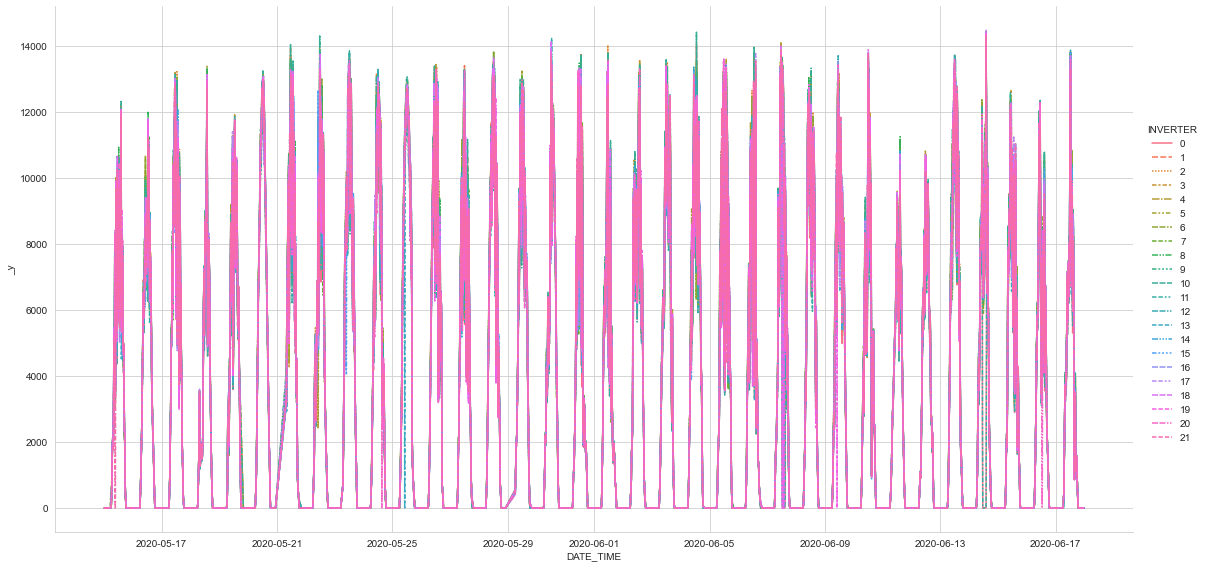

In [80]:
razem = to_correlation.pivot('DATE_TIME','INVERTER','DC_POWER')
plot3 = sns.relplot(data = razem, kind='line', height=8, aspect=2) #aspect*height = width

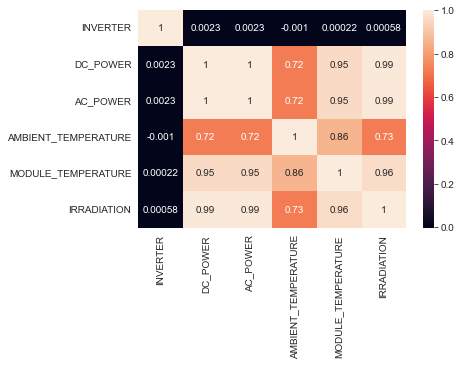

In [81]:
cor_matrix = to_correlation.corr()
sns.heatmap(cor_matrix, annot=True)
plt.show()

In [82]:
to_PCA = to_correlation.iloc[:,4:]
to_PCA

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,25.184316,22.857507,0.0
1,25.184316,22.857507,0.0
2,25.184316,22.857507,0.0
3,25.184316,22.857507,0.0
4,25.184316,22.857507,0.0
...,...,...,...
68769,21.909288,20.427972,0.0
68770,21.909288,20.427972,0.0
68771,21.909288,20.427972,0.0
68772,21.909288,20.427972,0.0


In [83]:
label_encoder = preprocessing.LabelEncoder()
a['INVERTER'] = label_encoder.fit_transform(a['INVERTER']) 
a.head()

,DATE_TIME,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,0,0.0,0.0,0.0,6259559.0,25.184316,22.857507,0.0
1,2020-05-15,1,0.0,0.0,0.0,6183645.0,25.184316,22.857507,0.0
2,2020-05-15,2,0.0,0.0,0.0,6987759.0,25.184316,22.857507,0.0
3,2020-05-15,3,0.0,0.0,0.0,7602960.0,25.184316,22.857507,0.0
4,2020-05-15,4,0.0,0.0,0.0,7158964.0,25.184316,22.857507,0.0


In [84]:
scaling = StandardScaler()
scaled_data = scaling.fit_transform(to_PCA)
scaled_data

array([[-0.1113282 , -0.68145574, -0.76936117],
       [-0.1113282 , -0.68145574, -0.76936117],
       [-0.1113282 , -0.68145574, -0.76936117],
       ...,
       [-1.08566918, -0.87884742, -0.76936117],
       [-1.08566918, -0.87884742, -0.76936117],
       [-1.08566918, -0.87884742, -0.76936117]])

In [85]:
columns_to_PCA = to_PCA.columns
predictors_to_PCA = pd.DataFrame(scaled_data, columns=columns_to_PCA)
timestamp_labels = pd.DataFrame(a.loc[:, ['DATE_TIME','AC_POWER']])

In [86]:
calculating_PCA = PCA(n_components=1)
calculating_PCA.fit(predictors_to_PCA)
from_PCA = calculating_PCA.transform(predictors_to_PCA)
print('Explained variance ratio: {}'.format(calculating_PCA.explained_variance_ratio_))

Explained variance ratio: [0.8994827]


In [87]:
PCA_to_frame = pd.DataFrame(from_PCA)
dataset_after_PCA = timestamp_labels.merge(PCA_to_frame, left_index=True, right_index=True)
col_names = list(timestamp_labels.columns)
col_names.append('PCA_PREDICTOR')
dataset_after_PCA.columns = col_names
dataset_after_PCA

,DATE_TIME,AC_POWER,PCA_PREDICTOR
0,2020-05-15 00:00:00,0.0,-0.916409
1,2020-05-15 00:00:00,0.0,-0.916409
2,2020-05-15 00:00:00,0.0,-0.916409
3,2020-05-15 00:00:00,0.0,-0.916409
4,2020-05-15 00:00:00,0.0,-0.916409
...,...,...,...
68769,2020-06-17 23:45:00,0.0,-1.571800
68770,2020-06-17 23:45:00,0.0,-1.571800
68771,2020-06-17 23:45:00,0.0,-1.571800
68772,2020-06-17 23:45:00,0.0,-1.571800


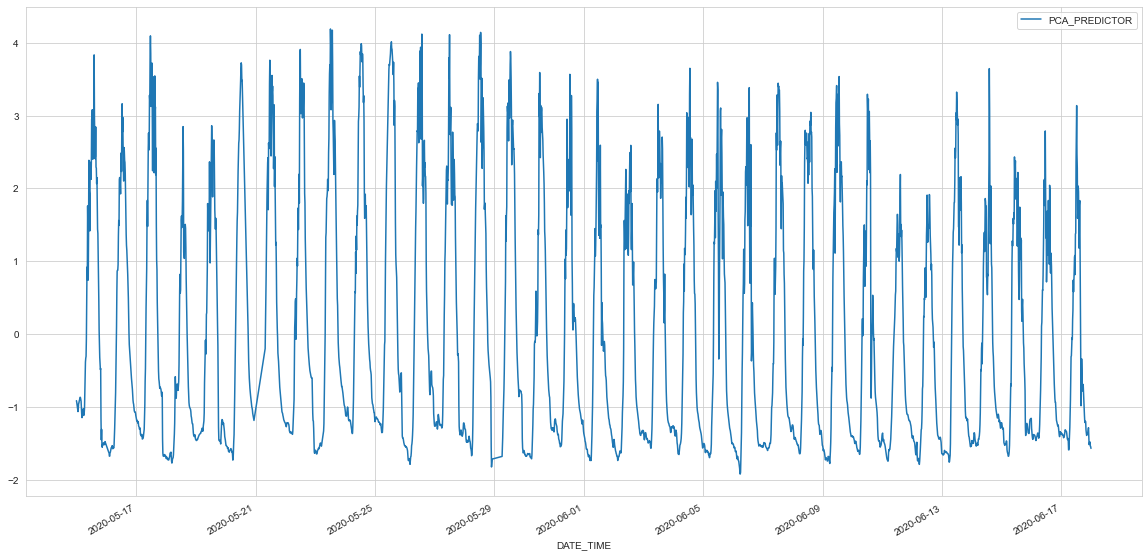

In [88]:
PCA_plot = dataset_after_PCA.plot(x='DATE_TIME', y='PCA_PREDICTOR', figsize=(20,10))
plt.show()

In [89]:
z

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.000000,143581676.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.000000,143581676.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.000000,143581676.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.000000,143581676.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.000000,150761642.0,24.621525,22.165423,0.0
...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,0.0,0.0,129571.000000,156142755.0,22.150570,21.480377,0.0
3153,2020-06-17 23:00:00,0.0,0.0,129571.000000,156142755.0,22.129816,21.389024,0.0
3154,2020-06-17 23:15:00,0.0,0.0,129571.000000,156142755.0,22.008275,20.709211,0.0
3155,2020-06-17 23:30:00,0.0,0.0,129571.000000,156142755.0,21.969495,20.734963,0.0
